In [92]:
# Importing the necessary libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [93]:
# Getting the stock quote
df = pd.read_csv('/content/MARUTI.NS.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,9749.000000,9789.000000,9629.799805,9651.900391,9150.262695,426354
1,2018-01-02,9699.000000,9718.599609,9525.000000,9554.049805,9057.500000,451227
2,2018-01-03,9597.000000,9598.000000,9402.000000,9416.599609,8927.193359,658281
3,2018-01-04,9450.000000,9488.000000,9367.200195,9386.250000,8898.421875,562919
4,2018-01-05,9458.000000,9532.000000,9412.549805,9433.849609,8943.547852,732512
...,...,...,...,...,...,...,...
1231,2022-12-26,8147.000000,8346.000000,8076.049805,8256.799805,8256.799805,315102
1232,2022-12-27,8298.950195,8315.000000,8230.799805,8305.450195,8305.450195,423308
1233,2022-12-28,8315.000000,8453.500000,8287.599609,8421.049805,8421.049805,538632
1234,2022-12-29,8370.000000,8449.000000,8333.000000,8435.799805,8435.799805,452134


In [94]:
# Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Converting the dataframe to a numpy array
dataset = data.values

Text(0, 0.5, 'Prices ($)')

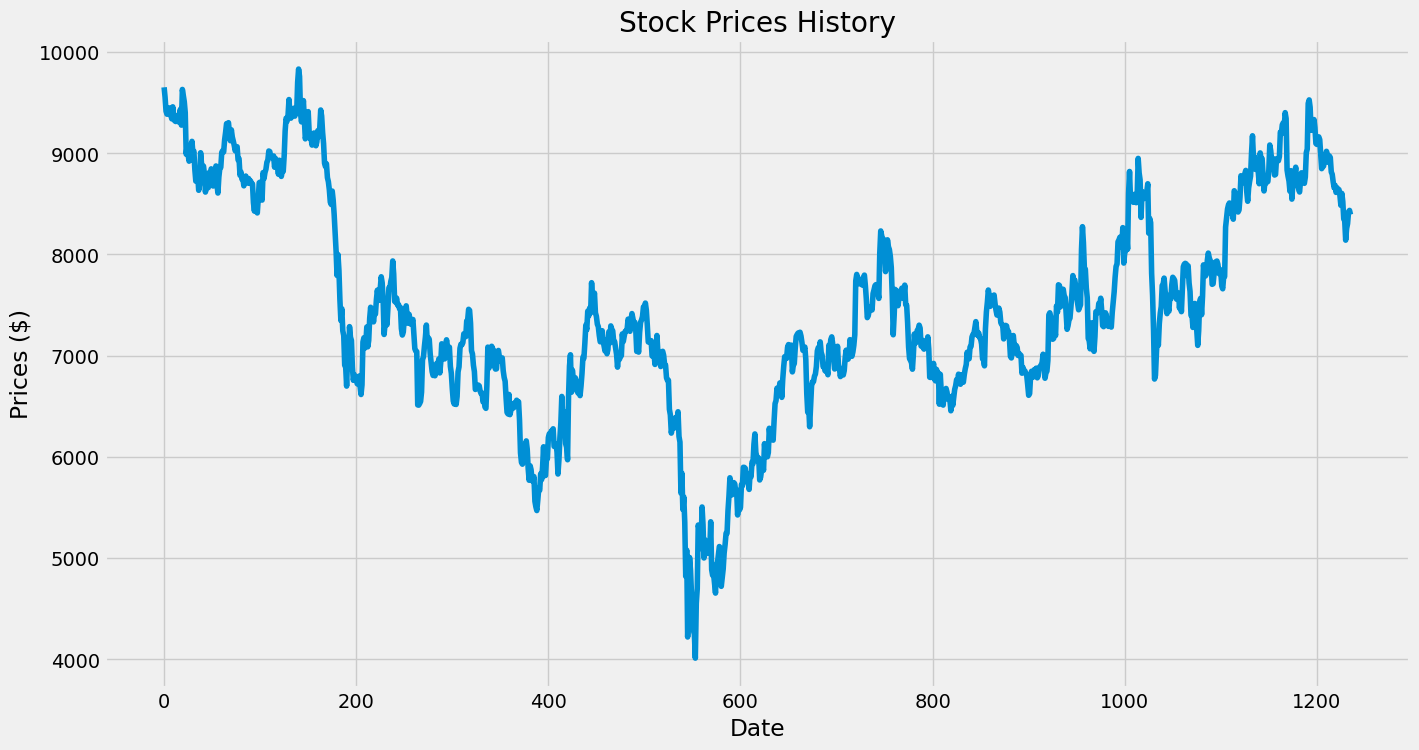

In [95]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [96]:
# Getting the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)

In [97]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [98]:
# Creating the training data set
train_data = scaled_data[0:training_data_len, :]

In [99]:
# Splitting the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [100]:
# Converting the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [101]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [102]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [114]:
# Training the model
model.fit(x_train, y_train, batch_size=5, epochs=1)

186/186 [==============================] - 7s 40ms/step - loss: 0.0022


In [115]:
# Creating the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Creating the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Converting the data to a numpy array
x_test = np.array(x_test)

# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [116]:
# Getting the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


8/8 [==============================] - 0s 12ms/step


In [117]:
# Getting the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE:', rmse)


RMSE: 17.698924211918037


In [118]:
# Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()

# Create a new column in the valid DataFrame for the predictions
valid['Predictions'] = predictions

# Use the .loc accessor to set the values for the new column
valid.loc[:, 'Predictions'] = predictions

In [119]:
predictions.shape

(247, 1)

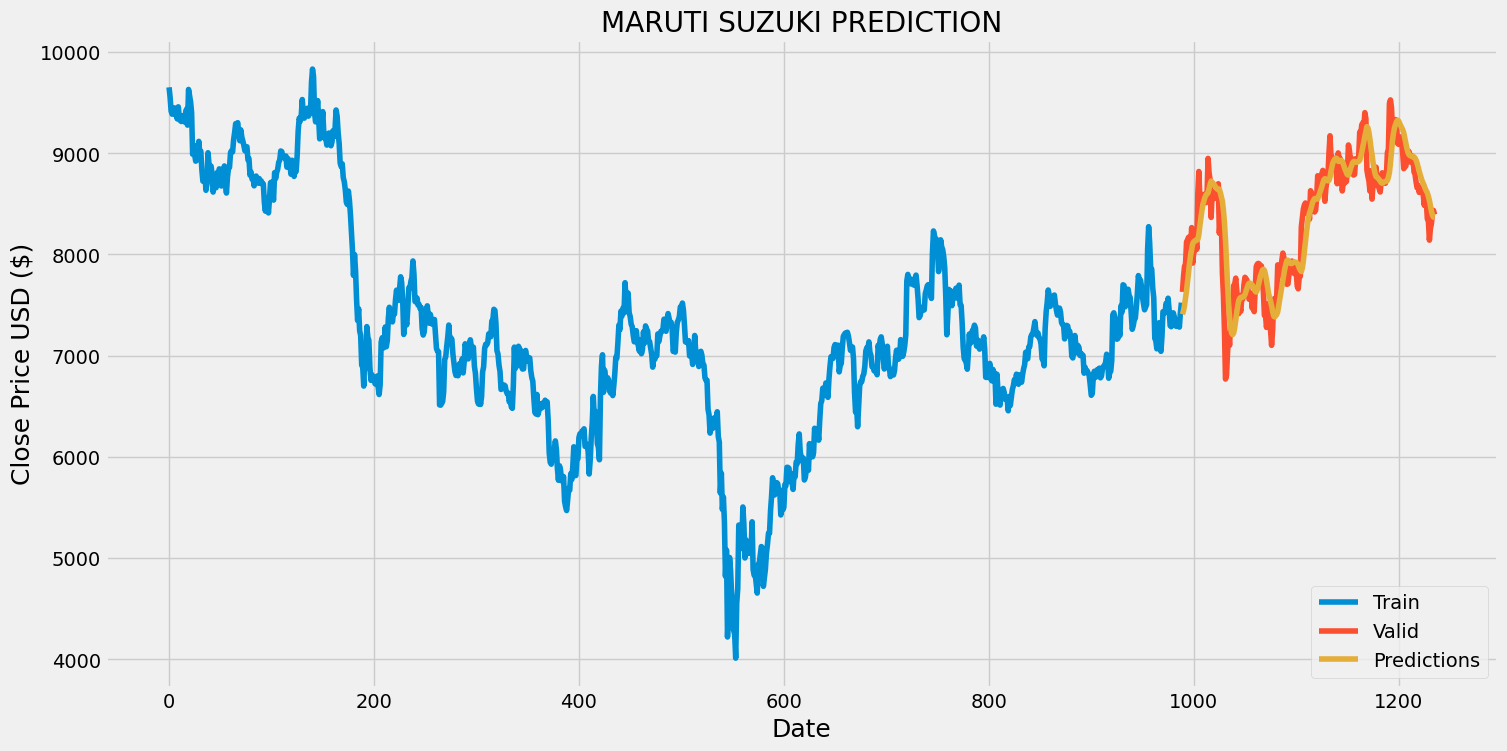

In [120]:
plt.figure(figsize=(16,8))
plt.title('MARUTI SUZUKI PREDICTION')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [121]:
# Predicting the stock prices for the next 365 days
Adani_power_quote = pd.read_csv('/content/MARUTI.NS.csv')
new_df = Adani_power_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print('Predicted price for the next day:', pred_price)


1/1 [==============================] - 0s 28ms/step
Predicted price for the next day: [[8368.092]]


In [122]:
forecast = []
forecast.append(pred_price)

for i in range(1, 365):
    last_60_days_scaled = scaler.transform(last_60_days[-60:].reshape(-1, 1))
    last_60_days = np.append(last_60_days[1:], pred_price)
    X_test = np.array([last_60_days_scaled])
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    forecast.append(pred_price)

1/1 [==============================] - 0s 25ms/step


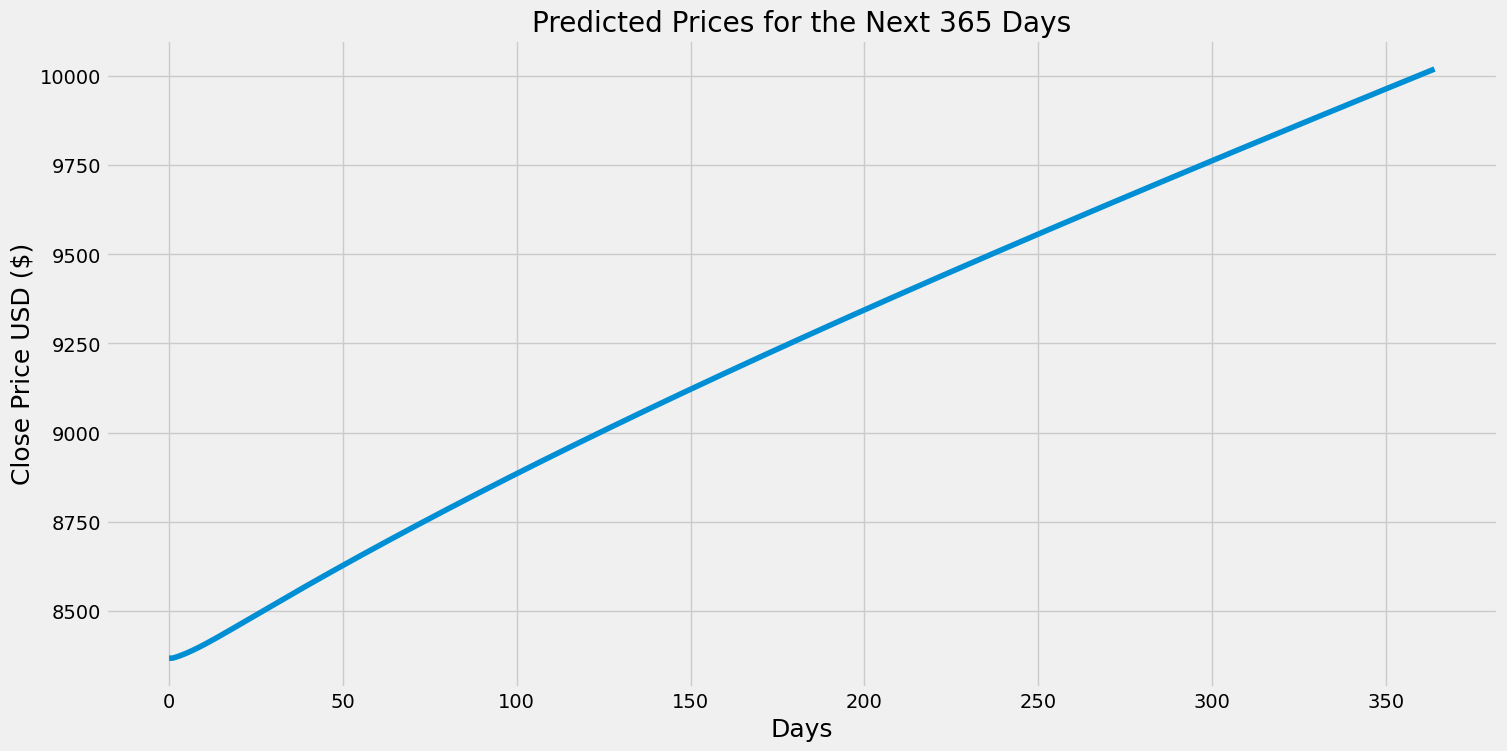

In [123]:
forecast = np.array(forecast).flatten()
plt.figure(figsize=(16,8))
plt.title('Predicted Prices for the Next 365 Days')
plt.xlabel('Days', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(forecast)
plt.show()

In [124]:
forecast

array([ 8368.092 ,  8368.092 ,  8370.963 ,  8374.274 ,  8377.97  ,
        8381.99  ,  8386.29  ,  8390.829 ,  8395.572 ,  8400.493 ,
        8405.563 ,  8410.758 ,  8416.061 ,  8421.449 ,  8426.913 ,
        8432.435 ,  8438.004 ,  8443.611 ,  8449.247 ,  8454.904 ,
        8460.578 ,  8466.261 ,  8471.952 ,  8477.644 ,  8483.338 ,
        8489.026 ,  8494.712 ,  8500.39  ,  8506.061 ,  8511.723 ,
        8517.376 ,  8523.017 ,  8528.647 ,  8534.267 ,  8539.875 ,
        8545.471 ,  8551.055 ,  8556.627 ,  8562.185 ,  8567.733 ,
        8573.267 ,  8578.789 ,  8584.298 ,  8589.797 ,  8595.281 ,
        8600.754 ,  8606.215 ,  8611.662 ,  8617.1   ,  8622.524 ,
        8627.936 ,  8633.338 ,  8638.727 ,  8644.104 ,  8649.469 ,
        8654.823 ,  8660.165 ,  8665.497 ,  8670.817 ,  8676.125 ,
        8681.424 ,  8686.711 ,  8691.986 ,  8697.251 ,  8702.505 ,
        8707.75  ,  8712.981 ,  8718.205 ,  8723.416 ,  8728.618 ,
        8733.81  ,  8738.991 ,  8744.161 ,  8749.322 ,  8754.4